# XGBoost trainer

This notebook function handles training and logging of xgboost models **only**, exposing both the sklearn and low level api's.

1. generate an xgboost model configuration by selecting one of 5 available types
2. get a sample of data from a data source (random rows, consecutive rows, or the entire dataset)
3. split the data into train, validation, and test sets.  

> _PLEASE NOTE_:  there are many approaches to cross validation (cv) and as many ways to implement cv in scikit learn.  In this thrid stage, an alternative, two-way train and test split can be created.  The training set would then, for example, serve as input to a cross validation splitter.  The latter creates multiple training and validation subsets, called folds. These folds are then input, either in sequence or in parallel into the fit algorithm.

4. train the model
5. dump the model
6. generate predictions, statistics and plots

All these steps have been separated here into independent functions since many can be reused for other model types. Some of the following functions will be transferred in the `mlrun.mlutils` module. Additionally, each function contains its own imports in order to isolate and identify dependencies.

In [1]:
# nuclio: ignore
import nuclio

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## generate an xgb model

In [3]:
def gen_xgb_model(model_type: str, xgb_params: dict):
    """generate an xgboost model
    
    Multiple model types that can be estimated using
    the XGBoost Scikit-Learn API
    
    :param model_type: one of "classifier", "regressor",
                       "ranker", "rf_classifier", or
                      "rf_regressor"
    :param xgb_params: parameters passed through the 
                       function execution context
    """
    from json import load
    from mlrun.mlutils import get_class_fit, create_class

    # generate model and fit function
    mtypes = {
        "classifier"   : "xgboost.XGBClassifier",
        "regressor"    : "xgboost.XGBRegressor",
        "ranker"       : "xgboost.XGBClassifier",
        "rf_classifier": "xgboost.XGBRFClassifier",
        "rf_regressor" : "xgboost.XGBRFRegressor"
    }
    if model_type not in mtypes.keys():
        raise Exception("unrecognized model types, see help documentation")
    
    model_config = get_class_fit(mtypes[model_type])

    for k, v in xgb_params:
        if k.startswith("CLASS_"):
            model_config["CLASS"][k[6:]] = v
        if k.startswith("FIT_"):
            model_config["FIT"][k[4:]] = v

    ClassifierClass = create_class(model_config["META"]["class"])
    model = ClassifierClass(**model_config["CLASS"])

    return model, model_config

### test

In [5]:
def test_gen_xgb_model():
    import xgboost
    c, j = gen_xgb_model("rf_classifier", {})
    assert isinstance(c, xgboost.XGBRFClassifier)
test_gen_xgb_model()    

## get a sample of data

In [6]:
def get_sample(src:str, sample: int, label: str, reader=None):
    """generate data sample to be split (candidate for mlrun)
     
    Returns features matrix and header (x), and labels (y)
    :param src:    full path and filename of data artifact
    :param sample: sample size from data source, use negative 
                   integers to sample randomly, positive to
                   sample consecutively from the first row
    :param label:  label column title
    :param reader: pandas type reader (read_csv, read_parquet, ...) returning
                   a pandas dataframe, and with a `dropna` attribute
    """
    import pandas as pd
    
    # read data function -- deprecate/add new mlrun dataset functionality
    if not reader:
        if src.endswith("csv"):
            reader = pd.read_csv
        elif src.endswith("parquet") or src.endswith("pq"):
            reader = pd.read_parquet
        else:
            raise Exception(f"file type unhandled {src}")

    # get sample
    if (sample == -1) or (sample >= 1):
        # get all rows, or contiguous sample starting at row 1.
        raw = reader(src).dropna()
        labels = raw.pop(label)
        raw = raw.iloc[:sample, :]
        labels = labels.iloc[:sample]
    else:
        # grab a random sample
        raw = reader(src).dropna().sample(sample * -1)
        labels = raw.pop(label)

    return raw, labels, raw.columns.values

### test

In [34]:
def test_get_sample():
    from mlrun import mlconf
    r, l, h = get_sample(mlconf.artifact_path+"/breast_cancer.parquet", -1, "labels")
    assert r.shape[0]==l.shape[0]
test_get_sample()

## split data into train, validate and test

this is only **one** approach to cross validation, essentially the simplest


In [9]:
def get_splits(
    raw, 
    labels, 
    three_way: bool = True,
    test_size: float = 0.15,
    valid_size: float = 0.30,
    label_names: list = ["labels"],
    random_state: int = 1
):
    """generate train and test sets (candidate for mlrun)

    cross validation:
    1. cut out a test set
    2a. use the training set in a cross validation scheme, or
    2b. make another split to generate a validation set
    
    :param raw:            dataframe or numpy array of raw features
    :param labels:         dataframe or numpy array of raw labels
    :param test_size:      proportion of raw data to set asid as test data
    :param valid_size:     proportion of remaining data to be set as validation
    :param labels:         label names
    :param random_state:   (1) random number seed
    """
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    
    if isinstance(raw, np.ndarray):
        if labels.ndim==1:
            labels=labels.reshape(-1,1)
        xy = np.concatenate([raw, labels], axis=1)
    else:
        if isinstance(labels, pd.Series):
            labels = pd.DataFrame(data=labels, columns=label_names)
        xy = pd.concat([raw, labels], axis=1)
        
    x, xte, y, yte = train_test_split(xy,
                                      labels, test_size=test_size,
                                      random_state=random_state)
    if not three_way:
        return (x, y), (xte, yte), None
    else:
        xtr, xva, ytr, yva = train_test_split(x, y,train_size=valid_size,
                                              random_state=random_state)
        return (xtr, ytr), (xva, yva), (xte, yte)

### test

In [11]:
def test_get_splits():
    from mlrun import mlconf
    r, l, h = get_sample(mlconf.artifact_path+"/breast_cancer.parquet", -1, "labels")
    (xtr, ytr), (xva, yva), (xte, yte) = get_splits(r,l)
    assert xtr.shape[0]+xva.shape[0]+xte.shape[0] == r.shape[0]
test_get_splits()

## save the test data separately

In [12]:
def save_test_set(
    context, 
    xtest, 
    ytest, 
    header: list, 
    label: str = "labels", 
    file_ext: str = "parquet", 
    index: bool = False 
):
    """save a held out test set

    :param context:    the function execution context
    :param xtest:      test features, as np.ndarray output from `get_splits`
    :param ytest:      test labels, as np.ndarray output from `get_splits`
    :param header:     ([])features header if required
    :param label:      ("labels") name of label column
    :param file_ext:   format of test set file
    :param index:      preserve index column
    """
    import pandas as pd
    
    test_set = pd.concat(
        [pd.DataFrame(data=xtest, columns=header),
         pd.DataFrame(data=ytest.values, columns=[label])],
        axis=1,)
    
    context.log_dataset("test_set", df=test_set, format=file_ext, index=False)

### test

In [13]:
def test_save_test_set(params):
    r, l, h = get_sample(mlconf.artifact_path+"/breast_cancer.parquet", -1, "labels")
    (xtr, ytr), (xva, yva), (xte, yte) = get_splits(r,l)
    save_test_set(xte, yte)
    import pandas as pd
    # pd.read_parquet()
    # assert

## dump an xgb model

In [14]:
def dump_xgb_model(
    context, 
    model,
    dump_type: str,
    dest_folder: str,
    dest_name: str
):
    """serialize/log model
    
    XGBoost model can be save in 3 different ways:
    1. pickle the internal _booster object, inside the model
    2. using model.save_model("fn.bin") using a legacy binary xgb format
    2. using model.save_model("fn.json") using a portable json format
    
    :param context:     the function"s execution context
    :param model:       the fitted xgboost model
    :param dump_type:   "pickle" legacy", or "json", 
    :param dest_folder: path for serialized model 
    :param dest_name:   name for serialized model file
    """
    from cloudpickle import dumps
    try:
        # if dump_type is "pickle":
        # https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier.save_model
        model.save_model(f"{dest_folder}/{dest_name}-save_model.pkl")
        
        # elif dump_type is "json":
        # see https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
        # this save all contents as json
        model.save_model(f"{dest_folder}/{dest_name}-save_model.json")
        
        # else:
        # this saves all internal contents as pickle
        _booster = model.get_booster()
        dump(_booster, open(f"{dest_folder}/{dest_name}-dump.pkl", "wb"))
        
        # log model needs to be spec"ed:
        data = dumps(_booster)
        context.log_artifact("model", body=data, local_path=f"{dest_folder}/{dest_name}.pkl")
    except Exception as e:
        print("xgboost model serialization error", str(e))

### test

In [16]:
def test_dump_xgb_model_pickle():
    """
    note that this approach doesn't require information
    about the underlying package, xgboost
    """
    from cloudpickle import load
    from mlrun import mlconf
    
    booster = load(open(mlconf.artifact_path + "/models/xgb-dump.pkl", "rb"))
    assert "booster" in booster.__dict__.keys()

test_dump_xgb_model_pickle()

def test_dump_xgb_save_model():
    import xgboost as xgb
    from mlrun import mlconf

    booster = xgb.Booster()
    booster.load_model(fname=mlconf.artifact_path + "/models/xgb-save_model.pkl")
    assert "booster" in booster.__dict__.keys()

test_dump_xgb_save_model()

def test_dump_xgb_json_save_model():
    import xgboost as xgb
    from mlrun import mlconf

    booster = xgb.Booster()
    booster.load_model(fname=mlconf.artifact_path + "/models/xgb-save_model.json")
    assert "booster" in booster.__dict__.keys()

test_dump_xgb_json_save_model()

In [17]:
def plot_confusion_matrix(
    labels,
    predictions,
    classes,
    normalize="all",
    title='Confusion matrix',
    cmap=None
):
    """prints and plots the confusion matrix.
    
    """
    import matplotlib.pyplot as plt
    from sklearn import metrics
    import itertools
    
    if not cmap:
        cmap = plt.cm.Blues

    cm = metrics.confusion_matrix(labels, predictions, normalize=normalize)
    
    # plt.gcf().set_size_inches(30, 10)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
def gen_proba(
    context,
    feats,
    labels,
    model,
    score_method,
    plots_dest,
    ntree_limit=None,
    validate_features=True,
    base_margin=None
):
    """ generate predictions and validation stats
    
    :param context:           the function execution context
    :param feats:             validation features array 
    :param labels:            validation ground-truth labels
    :param model:             estimated model
    :param scrore_method:     ("average") multiclass scoring
    :param plots_dest:        destination folder for plot artifacts
    :param ntree_limit:       (None) limit no. trees used in prediction
    :param validate_features: (True) ensure consistent feature names 
                              between model and input data
    :param base_margin:       (None) undefined
    """
    from sklearn import metrics
    from mlrun.artifacts import PlotArtifact
    from mlrun.mlutils import gcf_clear
    from xgboost import XGBClassifier, DMatrix
    import matplotlib.pyplot as plt
    
    clf = XGBClassifier()
    clf._Booster = model
    ypred = model.predict(DMatrix(feats)) #, False, ntree_limit, validate_features, base_margin)
    
    y_proba = []
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(feats, ntree_limit, validate_features, base_margin)
    ypred_binary = [round(value) for value in y_proba[:,-1]]
    
    average_precision = metrics.average_precision_score(labels, y_proba[:,-1], average=score_method)
    context.log_result(f"avg_precision", average_precision)
    context.log_result(f"rocauc", metrics.roc_auc_score(labels, y_proba[:,-1]))
    context.log_result(f"accuracy_score", float(metrics.accuracy_score(labels, ypred_binary)))
    context.log_result(f"f1_score", metrics.f1_score(labels, ypred_binary, average=score_method))
    
    # ROC plot
    context.log_artifact(PlotArtifact("roc", body=plot_roc(context, labels, y_proba)),
                         local_path=f"{plots_dest}/roc.html")
    gcf_clear(plt)

    # plot_confusion_matrix (sklearn.metrics version doesn"t return a body)
    plot_confusion_matrix(labels, ypred_binary, classes=labels.labels.unique()) 
    context.log_artifact(PlotArtifact("confusion", body=plt.gcf()), local_path=f"{plots_dest}/confusion.html")
    
    return y_proba

In [48]:
def plot_roc(
    context,
    y_labels,
    y_probs,
    fpr_label: str = "false positive rate",
    tpr_label: str = "true positive rate",
    title: str = "roc curve",
    legend_loc: str = "best",
):
    """plot roc curves

    TODO:  add averaging method (as string) that was used to create probs, 
    display in legend

    :param context:      the function context
    :param y_labels:     ground truth labels, hot encoded for multiclass  
    :param y_probs:      model prediction probabilities
    :param key:          ("roc") key of plot in artifact store
    :param plots_dir:    ("plots") destination folder relative path to artifact path
    :param fmt:          ("png") plot format
    :param fpr_label:    ("false positive rate") x-axis labels
    :param tpr_label:    ("true positive rate") y-axis labels
    :param title:        ("roc curve") title of plot
    :param legend_loc:   ("best") location of plot legend
    """
    from sklearn import metrics
    import matplotlib.pyplot as plt
    from mlrun.mlutils import gcf_clear
    
    # clear matplotlib current figure
    gcf_clear(plt)

    # draw 45 degree line
    plt.plot([0, 1], [0, 1], "k--")

    # labelling
    plt.xlabel(fpr_label)
    plt.ylabel(tpr_label)
    plt.title(title)
    plt.legend(loc=legend_loc)

    # single ROC or mutliple
    print(y_labels.shape)
    if y_labels.ndim > 2:
        # data accummulators by class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_labels[:, :-1].shape[1]):
            fpr[i], tpr[i], _ = metrics.roc_curve(
                y_labels[:, i], y_probs[:, i], pos_label=1
            )
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f"class {i}")
    else:
        fpr, tpr, _ = metrics.roc_curve(y_labels, y_probs[:,-1])
        plt.plot(fpr, tpr, label=f"positive class")

    return plt.gcf()

[mlrun] 2020-04-27 21:00:45,844 logging run results to: http://mlrun-api:8080


No handles with labels found to put in legend.


(144, 1)
[mlrun] 2020-04-27 21:00:46,133 log artifact roc at /User/artifacts/plots/roc.html, size: 16202, db: Y
[mlrun] 2020-04-27 21:00:46,273 log artifact confusion at /User/artifacts/plots/confusion.html, size: 12260, db: Y


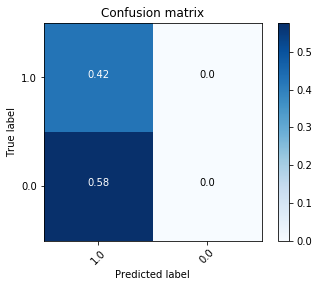

In [50]:
def test_gen_proba():
    from cloudpickle import load
    from mlrun import mlconf, get_or_create_ctx
    
    model = load(open(mlconf.artifact_path+'/models/xgb-dump.pkl', 'rb'))
    r, l, h = get_sample(mlconf.artifact_path+"/breast_cancer.parquet", -1, "labels")
    (xtr, ytr), (xva, yva), (xte, yte) = get_splits(r,l)
    y_proba = gen_proba(get_or_create_ctx('test'),
                        xtr, ytr, model, "macro",
                        mlconf.artifact_path+'/plots')
    return y_proba, model

y_proba, model = test_gen_proba()

In [56]:
dir(model)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_validate_features',
 'attr',
 'attributes',
 'best_iteration',
 'best_ntree_limit',
 'boost',
 'booster',
 'copy',
 'dump_model',
 'eval',
 'eval_set',
 'feature_names',
 'feature_types',
 'get_dump',
 'get_fscore',
 'get_score',
 'get_split_value_histogram',
 'handle',
 'load_config',
 'load_model',
 'load_rabit_checkpoint',
 'predict',
 'save_config',
 'save_model',
 'save_rabit_checkpoint',
 'save_raw',
 'set_attr',
 'set_param',
 'trees_to_dataframe',
 'update']

In [ ]:
def train_model(
    context,
    model_type: str,
    dataset,
    label_column: str = "labels",
    sample: int = -1,
    test_size: float = 0.05,
    valid_size: float = 0.75,
    random_state: int = 1,
    model_filename: str = "model",
    models_dest: str = "",
    plots_dest: str = "",
    score_method: str = "micro",
    file_ext: str = "parquet",
    model_pkg_file: str = "",    
) -> None:
    """train an xgboost model.

    :param context:           the function context
    :param model_pkg_class:   the model to train, e.g, "sklearn.neural_networks.MLPClassifier", 
                              or json model config
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param model_filename:    model file filename,
                              points to a directory
    :param test_size:         (0.05) test set size
    :param valid_size:          (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param random_state:      (1) sklearn rng seed
    :param models_dest:       models subfolder on artifact path
    :param plots_dest:        plot subfolder on artifact path
    :param score_method:      for multiclass classification
    
    :param file_ext:          format for test_set_key hold out data
    :param model_pkg_file:    json model config file                                  
    """
    # deprecate:
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(str(dataset), sample, label_column)
    
    # split the sample into train validate and test sets:
    (xtr,ytr), (xva,yva), (xte,yte) = get_splits(raw, labels, test_size, valid_size, random_state)
        
    # get xgboost model and model config
    model, model_config = gen_xgb_model(model_type, context.parameters.items())
    
    # update the model config with training data and callbacks
    model_config["FIT"].update({"X": xtr,"y": ytr.values})
    
    # run the fit
    model.fit(**model_config["FIT"])
    
    # serialize the model
    dump_xgb_model(context, model, "json", models_dest, model_filename)

    # generate predictions
    y_proba = gen_proba(context, xva, yva, model, score_method, plots_dest)

In [37]:
# nuclio: end-code

### mlconfig

In [38]:
from mlrun import mlconf

In [39]:
mlconf.dbpath = mlconf.dbpath or "./"
mlconf.dbpath

'http://mlrun-api:8080'

In [40]:
vcs_branch = "development"
base_vcs = f"https://raw.githubusercontent.com/mlrun/functions/{vcs_branch}/"

mlconf.hub_url = mlconf.hub_url or base_vcs + f"{name}/function.yaml"
mlconf.hub_url

'/User/repos/functions/{name}/function.yaml'

In [41]:
import os
mlconf.artifact_path = mlconf.artifact_path or f"{os.environ['V3IO_HOME']}/artifacts"
mlconf.artifact_path

'/User/artifacts'

In [42]:
import os
TAG = os.environ["MLRUN_COMMIT"]

### save

In [43]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("xgb_trainer", kind="job", with_doc=True,
                      handler=train_model,
                      image=f"mlrun/ml-models:{TAG}")

# add metadata (for templates and reuse)
fn.spec.default_handler = "train_model"
fn.spec.description = "train any classifier using scikit-learn's API"
fn.metadata.categories = ["models", "classifier"]
fn.metadata.labels = {"author": "yjb"}

fn.save()
fn.export("function.yaml")

[mlrun] 2020-04-27 20:59:07,819 saving function: xgb-trainer, tag: latest
[mlrun] 2020-04-27 20:59:07,917 function spec saved to path: function.yaml


### test

In [44]:
from mlrun import import_function, mount_v3io, NewTask, run_local

func = import_function("hub://xgb_trainer")

if "V3IO_HOME" in list(os.environ):
    # mlrun on the iguazio platform
    from mlrun import mount_v3io
    fn.apply(mount_v3io())
else:
    # mlrun is setup using the instructions at 
    # https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    fn.apply(mount_pvc("nfsvol", "nfsvol", "/home/joyan/data"))

In [45]:
gpus = False

task_params = {
    "name" : "tasks xgb cpu trainer",
    "params" : {
        "model_type"         : "classifier", # choose regressor, ranker, rfclassifier...
        "num_class"          : 2,  # do not use this when binary
        "CLASS_tree_method"  : "gpu_hist" if gpus else "hist",
        "CLASS_objective"    : "binary:logistic",  # have this chosen by default
        "CLASS_random_state" : 1,
        "sample"             : -1,
        "label_column"       : "labels",
        "test_size"          : 0.10,
        "valid_size"         : 0.75,
        "score_method"       : "weighted",
        "models_dest"        : os.path.join(mlconf.artifact_path, "models"),
        "plots_dest"         : os.path.join(mlconf.artifact_path, "plots"),
    }}

### run remotely

In [46]:
run = fn.run(
    NewTask(**task_params),
    inputs={"dataset"  : os.path.join(mlconf.artifact_path, "breast_cancer.parquet")},
    artifact_path=mlconf.artifact_path)

[mlrun] 2020-04-27 20:59:08,036 starting run tasks xgb cpu trainer uid=6decaf0d88214f6c92052cb2cb93b4fe  -> http://mlrun-api:8080
[mlrun] 2020-04-27 20:59:08,292 Job is running in the background, pod: tasks-xgb-cpu-trainer-rt886
Traceback (most recent call last):
  File "/opt/conda/bin/mlrun", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 717, in main
    rv = self.invoke(ctx)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 956, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 555, in invoke
    return callback(*args, **kwargs)
  File "/opt/conda/lib/python3.7/sit

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...cb93b4fe,0,Apr 27 20:59:11,error,tasks xgb cpu trainer,kind=jobowner=adminv3io_user=admin,dataset,CLASS_objective=binary:logisticCLASS_random_state=1CLASS_tree_method=histlabel_column=labelsmodel_type=classifiermodels_dest=/User/artifacts/modelsnum_class=2plots_dest=/User/artifacts/plotssample=-1score_method=weightedtest_size=0.1valid_size=0.75,,


to track results use .show() or .logs() or in CLI: 
!mlrun get run 6decaf0d88214f6c92052cb2cb93b4fe  , !mlrun logs 6decaf0d88214f6c92052cb2cb93b4fe 
[mlrun] 2020-04-27 20:59:14,434 run executed, status=error
runtime error: error, check logs


RunError: error, check logs